This template notebook should serve as a guide for how to load and manipulate the dataset, and the different preprocessing methods you may choose to implement (you are welcome to try any others outside of what is provided here). This code should be treated as pseudo-code - and you may have to debug this code to get it working adequately.

In this notebook, we only access the labeled portion of the training dataset, and directly run/train/fit supervised methods. e.g., Multinomial Naive Bayes and Linear SGD classifiers (linear SGD [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html] implements regularized linear models with stochastic gradient descent, e.g., by choosing loss=‘log_loss’, you obtain a logistic regression classifier), on only this labeled portion of the training dataset. The performance values you get from running this experiment will serve as your baseline.

Once you have these baseline numbers for the configuration of preprocessing and supervised methods you choose (ideally at least 2 preprocessing methods and also at least 2 supervised methods), you can now begin working on Part 1: i.e. using unsupervised learning methods to automate adding labels to the unlabelled portion of the train dataset. The goal is to see if adding these newly labeled data examples to the train set will improve the baseline numbers you obtained (i.e. Part 2: running the supervised methods you chose for the baseline on the newly augmented dataset and reporting the performance on this augmented dataset).

Lastly, please note that there is a class imbalance in the train, test, and val sets. You will have to incorporate an approach to deal with this.

Baseline results

BOW NB: 0.506
BOW SGD: 0.497

CountVectorizer/TFIDF NB: 0.577
CountVectorizer/TFIDF SGD: 0.589


Our results

BOW NB: 0.488
BOW SGD: 0.485

CountVectorizer/TFIDF NB: 0.520
CountVectorizer/TFIDF SGD: 0.534

In [39]:
# import packages

import os
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression as sk_OLS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import math

from sklearn.metrics import r2_score
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

In [40]:
ORIGINAL_LABEL = 'Sentiment'
AUGMENTED_LABEL = 'final_label'
NUM_CLASSES = 5
UNLABELLED_VALUE = -100

## Download the data

In [41]:
# Create a folder within MyDrive (default google drive location) called sample_data
# Upload all data files there
FILE_PATH = "../data/"
train_data = pd.read_csv(FILE_PATH + "train.csv")
val_data = pd.read_csv(FILE_PATH + "val.csv")
test_data = pd.read_csv(FILE_PATH + "test.csv")

In [42]:
# get all train data (labelled and unlabelled)
X_train    = train_data['Phrase']
y_train    = train_data['Sentiment']

# get only labelled train data
mask = (y_train != -100)
train_data_clean    = train_data[mask]
X_train_clean    = X_train[mask]
y_train_clean    = y_train[mask]

# get val data
X_val    = val_data['Phrase']
y_val    = val_data['Sentiment']

# get test data
X_test     = test_data['Phrase']

print(f"Train Data Shape: {X_train.shape}")
print(f"Cleaned Train Data Shape: {train_data_clean['Phrase'].shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

print(" ")
print(f"Number of labels = 0 in train dataset as percentage: {((y_train == 0).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in train dataset as percentage: {((y_train == 3).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in train dataset as percentage: {((y_train == 4).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in train dataset as percentage: {((y_train == -100).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 0 in val dataset as percentage: {((y_val == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_val == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_val == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in val dataset as percentage: {((y_val == -100).sum() / (X_val.shape[0])) * 100:0.2f}%")

Train Data Shape: (109242,)
Cleaned Train Data Shape: (43697,)
Validation Data Shape: (23409,)
Test Data Shape: (23409,)
 
Number of labels = 0 in train dataset as percentage: 1.75%
Number of labels = 1 in train dataset as percentage: 6.91%
Number of labels = 2 in train dataset as percentage: 20.52%
Number of labels = 3 in train dataset as percentage: 8.46%
Number of labels = 4 in train dataset as percentage: 2.37%
Number of labels = -100 in train dataset as percentage: 60.00%
 
Number of labels = 0 in val dataset as percentage: 4.52%
Number of labels = 1 in val dataset as percentage: 17.47%
Number of labels = 2 in val dataset as percentage: 50.61%
Number of labels = 3 in val dataset as percentage: 21.33%
Number of labels = 4 in val dataset as percentage: 6.08%
Number of labels = -100 in val dataset as percentage: 0.00%


# Define Preprocessing Helper Functions

In [43]:
def get_most_common_label(value_counts):
    most_common_label = None
    most_common_label_freq = 0
    for label, cnt in value_counts.to_dict().items():
        if label == -100:
            continue
        elif cnt > most_common_label_freq:
            most_common_label = label
            most_common_label_freq = cnt

    return most_common_label, most_common_label_freq

def balance_classes(df, class_label_column_name='final_label'):

    cnts = df[class_label_column_name].value_counts()

    most_common_label, most_common_label_freq = get_most_common_label(cnts)

    df_balanced = df[df[class_label_column_name] == most_common_label]
    for i in range(NUM_CLASSES):
        if i == most_common_label:
            continue

        class_i = df[df[class_label_column_name] == i]
        class_i_over = class_i.sample(most_common_label_freq, replace=True)

        df_balanced = pd.concat([df_balanced, class_i_over], axis=0)

    df_balanced = pd.concat([df_balanced, df[df[class_label_column_name] == UNLABELLED_VALUE]], axis=0)

    print(df_balanced[class_label_column_name].value_counts())

    return df_balanced.sample(frac = 1)

In [44]:
# remove rows after preprocessing

# combine preprocessing for bow and countvec
# strategy: append columns then split

def remove_rows(df):
    df_copy = df.copy()
    df_copy = df_copy.apply(lambda text: set(text.split(" ")))

    # remove phrases with small number of words

    
    
    # check by each cluster to remove correlated examples
    # could choose to only do for class no 2

    # df = df[data['Phrase'].str.len() >0]

In [45]:
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('wordnet')

# # includes http removal, some random substitutions, 
# def clean(text):
#     # TODO did not remove stopwords. why is there a need for the preprocessing for BoW and countvec to be different
#     text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#     texter = re.sub(r"<br />", " ", text)
#     texter = re.sub(r"&quot;", "\"",texter)
#     texter = re.sub('&#39;', "\"", texter)
#     texter = re.sub('\n', " ", texter)
#     texter = re.sub(' u '," you ", texter)
#     texter = re.sub('`',"", texter)
#     texter = re.sub(' +', ' ', texter)
#     texter = re.sub(r"(!)\1+", r"!", texter)
#     texter = re.sub(r"(\?)\1+", r"?", texter)
#     texter = re.sub('&amp;', 'and', texter)
#     texter = re.sub('\r', ' ',texter)
#     #added substitutions

#     #***********added substitutions***********
#     # remove all the special characters
#     texter = re.sub(r'\W', ' ', texter)
#     # remove all single characters
#     texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
#     # Remove single characters from the start
#     texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
#     # Remove numbers
#     texter = re.sub(r'\d+', ' ', texter)
#     # Converting to Lowercase
#     texter = texter.lower()
#     # Remove punctuation
#     texter = re.sub(r'[^\w\s]', ' ', texter)
#     # Remove parentheses
#     texter = re.sub(r'\([^)]*\)', ' ', texter)
#     # Remove single quotes
#     texter = re.sub(r'\'', ' ', texter)
#     # Substituting multiple spaces with single space
#     texter = re.sub(r'\s+', ' ', texter, flags=re.I)

#     clean = re.compile('<.*?>')
#     texter = texter.encode('ascii', 'ignore').decode('ascii')
#     texter = re.sub(clean, '', texter)
#     if texter == "":
#         texter = ""
#     return texter

# def clean_dataset(dataset):
#     for row in range(dataset.shape[0]):
#         dataset[row,0] = clean(dataset[row,0])
#     return dataset

# def tokenize_lexicon(texts):
#     return_texts = []
#     for i in range(len(texts)):
#         return_texts.append(nltk.word_tokenize(texts[i]))
#         return_texts[i] = nltk.pos_tag(return_texts[i])
#     return return_texts

# def get_wordnet_pos(pos_tag):
#     if pos_tag.startswith('J'):
#         return wn.ADJ
#     elif pos_tag.startswith('V'):
#         return wn.VERB
#     elif pos_tag.startswith('N'):
#         return wn.NOUN
#     elif pos_tag.startswith('R'):
#         return wn.ADV
#     else:
#         return wn.NOUN

# def lemmatize_texts(texts):
#     return_texts = []
#     lemmer = nltk.stem.WordNetLemmatizer()
#     for i in range(len(texts)):
#         return_texts.append([])
#         for j in range(len(texts[i])):
#                 return_texts[i].append(lemmer.lemmatize(texts[i][j][0], pos=get_wordnet_pos(texts[i][j][1])))
#     return return_texts

# def stem_texts(texts):
#     return_texts = []
#     ps = PorterStemmer()
#     for i in range(len(texts)):
#         return_texts.append([])
#         for j in range(len(texts[i])):
#                 return_texts[i].append(ps.stem(texts[i][j][0]))
#     return return_texts


# def backtostring(texts):
#     return_texts = []
#     for i in range(len(texts)):
#         return_texts.append(" ".join(texts[i]))
#     return return_texts

# Preprocess using Bag of Words

In [60]:
# includes lowercase, removal of punctuation, remove of stopwords, lemmatization, url substitution
def preprocess(data): # this pre_process is specific to BoW??
    preproc_data = data.copy()
    preproc_data = preproc_data.str.lower()
    punctuation = string.punctuation
    mapping = str.maketrans("", "", punctuation)
    preproc_data = preproc_data.str.translate(mapping)
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    preproc_data = preproc_data.apply(lambda text: ' '.join([word for word in text.split() if word.lower() not in stop_words]))
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    preproc_data = preproc_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))
    preproc_data = preproc_data.apply(lambda text: re.sub(r'@\w+', '', re.sub(r'http\S+|www\S+', '', text)))

    preproc_data =  preproc_data.apply(lambda text: additional_preprocess(text))

    return preproc_data

def additional_preprocess(text):
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)

    # remove all single characters
    texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
    # Remove single characters from the start
    texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
    # Remove numbers
    texter = re.sub(r'\d+', ' ', texter)

    # Remove parentheses
    texter = re.sub(r'\([^)]*\)', ' ', texter)
    # Remove single quotes
    texter = re.sub(r'\'', ' ', texter)
    # Substituting multiple spaces with single space
    texter = re.sub(r'\s+', ' ', texter, flags=re.I)

    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

# get the preprocessed data
X_train_preproc = preprocess(X_train) # TODO add remove rows
# update y_train

# dont remove rows from X_train_clean since it wont be used.
X_train_clean_preproc   = preprocess(X_train_clean)
X_val_preproc = preprocess(X_val)
X_test_preproc = preprocess(X_test)

print(X_train_preproc.head)
print(X_train_clean_preproc.head)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrystalquek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chrystalquek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrystalquek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chrystalquek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrystalquek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chrystalquek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrystalquek/nltk_data...
[nltk_data]   Package st

<bound method NDFrame.head of 0         every taste often funny collegiate grossout co...
1         bunch good actor flailing around caper neither...
2                                           vietnam picture
3                                                   fincher
4                                         pitiful directing
                                ...                        
109237                                    trademark villain
109238    earn share holiday box office pie although mov...
109239        moving tale love destruction unexpected place
109240                 love reading andor poetry mean check
109241                             drag audience enthusiasm
Name: Phrase, Length: 109242, dtype: object>
<bound method NDFrame.head of 3                                        fincher
4                              pitiful directing
5                                        version
9                                      best film
10                         one reason l

Bag of words model

In [47]:
combined_data = pd.concat([X_train_preproc, X_val_preproc, X_test_preproc])

Sentiment
-100.0    193173
 2.0       34265
 0.0       34265
 1.0       34265
 3.0       34265
 4.0       34265
Name: count, dtype: int64
<bound method NDFrame.head of                                                    Phrase  Sentiment
100721            film ultimately inspiring hallmark card     -100.0
5364                                         autocritique        3.0
22308   rifkin doubt fancy something hubert selby jr n...     -100.0
13101                           close get imitation movie        3.0
41486   luminous interview amazingly evocative film th...     -100.0
...                                                   ...        ...
19424   three lead produce adequate performance missin...        4.0
11860         promise new kind high delivers old bad trip     -100.0
91078                                   lessthanthrilling     -100.0
66935                                          love drive        1.0
76704   opaque selfindulgent plain goofy excuse movie ...     -100.0

[36

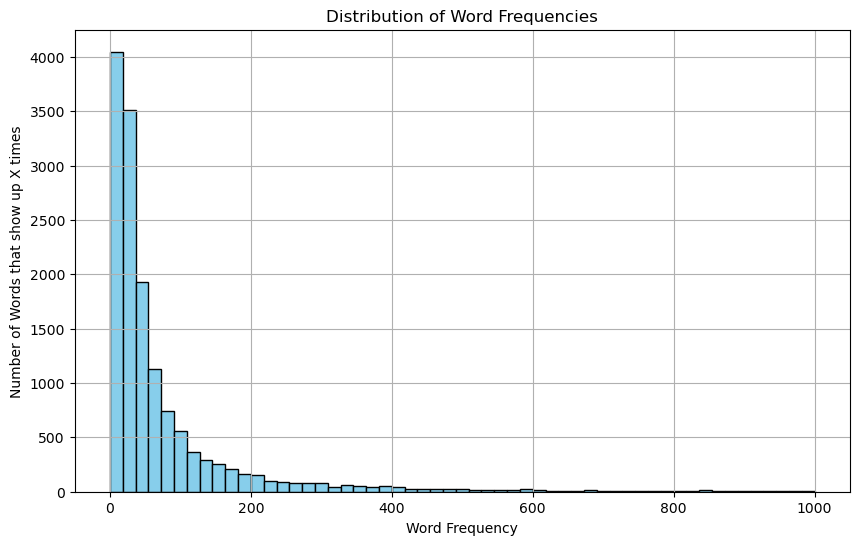

In [61]:
padding = np.zeros((combined_data.shape[0] - len(y_train) - len(y_val))) # might need to replace y_train if using another var
padding[:] = UNLABELLED_VALUE
labels = np.concatenate([np.array(y_train), np.array(y_val), padding])
combined_data = combined_data.to_frame()
combined_data[ORIGINAL_LABEL] = labels

combined_data = balance_classes(combined_data, ORIGINAL_LABEL)

print(combined_data.head)

combined_data = combined_data['Phrase']


text_data = combined_data
words = ' '.join(text_data).split()
word_freq_dict = Counter(words)

word_frequencies = list(word_freq_dict.values())

plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=55, color='skyblue', edgecolor='black', range=(0, 1000))
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words that show up X times')
plt.title('Distribution of Word Frequencies')
plt.grid(True)
plt.show()

Should i add max_df? apparently not...

action :   2209
bad :   3378
best :   2779
better :   1693
character :   5553
come :   2014
comedy :   4266
director :   2339
film :   16126
feel :   2719
good :   4202
like :   6039
make :   5063
performance :   3388

In [62]:

def bag_of_word(data, threshold_M, ngram_range=(1,1)):
    vectorizer = CountVectorizer(binary=True, max_features= threshold_M, ngram_range=ngram_range)
    vectorizer.fit(combined_data)
    print(vectorizer.get_feature_names_out())
    X = vectorizer.transform(data)
    featurized_data = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
    return featurized_data

# get the featurized data
BAG_OF_WORDS_NUM_WORDS = 500
X_train_bow_preproc_bow   = bag_of_word(X_train_preproc, BAG_OF_WORDS_NUM_WORDS)
X_val_bow_preproc_bow = bag_of_word(X_val_preproc, BAG_OF_WORDS_NUM_WORDS)
X_test_bow_preproc_bow = bag_of_word(X_test_preproc, BAG_OF_WORDS_NUM_WORDS)
print(X_train_bow_preproc_bow.head)

NGRAM_RANGE = (2,2)
NGRAMS_NUM_WORDS = 2000
X_train_ngram_bow_preproc_bow   = bag_of_word(X_train_preproc, NGRAMS_NUM_WORDS, NGRAM_RANGE)
X_val_ngram_bow_preproc_bow = bag_of_word(X_val_preproc, NGRAMS_NUM_WORDS, NGRAM_RANGE)
X_test_ngram_bow_preproc_bow = bag_of_word(X_test_preproc, NGRAMS_NUM_WORDS, NGRAM_RANGE)
print(X_train_ngram_bow_preproc_bow.head)

['act' 'acting' 'action' 'actor' 'actress' 'actually' 'adult' 'adventure'
 'age' 'almost' 'already' 'also' 'always' 'ambitious' 'american' 'amusing'
 'animation' 'another' 'anyone' 'anything' 'appeal' 'approach' 'around'
 'art' 'artist' 'attempt' 'attention' 'audience' 'away' 'awful' 'back'
 'bad' 'barely' 'beautiful' 'beautifully' 'beauty' 'become' 'becomes'
 'believe' 'best' 'better' 'beyond' 'big' 'bit' 'black' 'bland' 'book'
 'boring' 'boy' 'brilliant' 'ca' 'camera' 'capture' 'care' 'cast'
 'certainly' 'change' 'character' 'charm' 'charming' 'cheap' 'child'
 'cinema' 'cinematic' 'cinematography' 'classic' 'clever' 'cliche' 'cold'
 'come' 'comedy' 'comic' 'compelling' 'completely' 'complex' 'concept'
 'contrived' 'could' 'creative' 'credit' 'crime' 'culture' 'dark' 'date'
 'day' 'de' 'death' 'debut' 'deeply' 'delight' 'delightful' 'despite'
 'dialogue' 'different' 'directed' 'direction' 'director' 'documentary'
 'done' 'drag' 'drama' 'dramatic' 'dream' 'dry' 'dull' 'dumb' 'earnest'


Sklearn Multinomial NB

In [50]:
def run_nb(X, y, X_val, y_val):

    clf = MultinomialNB(alpha=1e-3)
    clf.fit(X, y)
    sk_y = clf.predict(X_val)

    print('Accuracy: ', accuracy_score(y_val, sk_y))

    print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

def run_sgd(X, y, X_val, y_val):

    clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
    clf_sgd.fit(X, y)
    y_pred = clf_sgd.predict(X_val)
    # print("Feature Count \n",clf_sgd.feature_count_)
    # print("Class Log Prior ",clf_sgd.class_log_prior_)
    print('Accuracy: ', accuracy_score(y_val, y_pred))
    # print(clf_sgd.predict_proba(X_test))

    print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")


def run_knn(X, y, X_val, y_val):

    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X, y)
    y_pred = clf.predict(X_val)

    print('Accuracy: ', accuracy_score(y_val, y_pred))
    # print(clf_sgd.predict_proba(X_test))

    print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")


def run_random_forest(X, y, X_val, y_val):

    clf = RandomForestRegressor(random_state=0)
    clf.fit(X, y)
    y_pred = clf.predict(X_val)

    print('Accuracy: ', accuracy_score(y_val, y_pred))
    # print(clf_sgd.predict_proba(X_test))

    print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")



In [51]:
baseline_X = bag_of_word(X_train_clean_preproc, 8)
baseline_X_val = bag_of_word(X_val_preproc, 8)

run_nb(baseline_X, y_train_clean, baseline_X_val, y_val)
run_sgd(baseline_X, y_train_clean, baseline_X_val, y_val)

['character' 'film' 'like' 'make' 'movie' 'nt' 'one' 'story']
['character' 'film' 'like' 'make' 'movie' 'nt' 'one' 'story']
Accuracy:  0.5060874022811739
Number of labels = 0 in val dataset as percentage: 0.00%
Number of labels = 1 in val dataset as percentage: 0.00%
Number of labels = 2 in val dataset as percentage: 100.00%
Number of labels = 3 in val dataset as percentage: 0.00%
Number of labels = 4 in val dataset as percentage: 0.00%
Accuracy:  0.497201930881285
Number of labels = 0 in val dataset as percentage: 0.30%
Number of labels = 1 in val dataset as percentage: 0.63%
Number of labels = 2 in val dataset as percentage: 90.08%
Number of labels = 3 in val dataset as percentage: 9.00%
Number of labels = 4 in val dataset as percentage: 0.00%


Sklearn Linear SGD Classifier

# Preprocess the data using CountVectorizer, nltk stem

In [69]:
def count_vectorizer(df, max_features=500, ngram_range=(1,1)):    
    # train set
    # train = clean_dataset(np.array(train_df))
    # val = clean_dataset(np.array(val_data))
    # test = clean_dataset(np.expand_dims(np.array(test_data["Phrase"]), axis = 1))
    # print(train[:,0].shape)
    # print(val[:,0].shape)
    # print(test[:,0].shape)
    # print(np.concatenate((train[:,0], test[:,0], val[:,0])).shape)

    # token_texts = tokenize_lexicon(np.concatenate((train[:,0], val[:,0], test[:,0])))
    # data = clean_dataset(combined_data[:,0])
    # remove rows from train
    # token_texts = tokenize_lexicon(data.to_numpy())

    # del train
    # del val
    # del test

    # if(lemma):
    #     lemm_texts = lemmatize_texts(token_texts)
    # else:
    #     lemm_texts = stem_texts(token_texts)
    # del token_texts
    # processed_texts = backtostring(lemm_texts)
    # del lemm_texts

    # matrix counts
    vectorizer = CountVectorizer(input='content', stop_words='english', min_df=5, max_features = max_features, ngram_range=ngram_range) # colab will crash
    X = vectorizer.fit_transform(combined_data)
    # print(vectorizer.get_feature_names_out())
    # del processed_texts
    # del vectorizer
    X_dense = X.todense()
    print(X_dense.shape)
    del X

    # tfidf
    tfidf_vectorizer = TfidfTransformer()
    X_tfidf = tfidf_vectorizer.fit(np.array(X_dense))
    del X_dense

    # transform only the data
    df_data = np.array(df)
    df_data = vectorizer.transform(df_data).todense()
    print(df_data)
    df_data = tfidf_vectorizer.transform(np.array(df_data))
    print(df_data)
    # df_data = df_data.todense()

    # print(tfidf_vectorizer.get_feature_names_out())

    return pd.DataFrame(data=df_data, columns=tfidf_vectorizer.get_feature_names_out())

    # X_data = pd.DataFrame(data=X_data, columns=vectorizer.get_feature_names_out())

    # X_train = X_data.iloc[:train_df['Phrase'].shape[0]]
    # X_val = X_data.iloc[train_df['Phrase'].shape[0]:train_df['Phrase'].shape[0]+val_data['Phrase'].shape[0]]
    # X_test = X_data.iloc[train_df['Phrase'].shape[0]+val_data['Phrase'].shape[0]:]
    # del X_data
    # print("X_train.shape: ", X_train.shape)
    # print("X_val.shape: ", X_val.shape)
    # print("X_test.shape: ", X_test.shape)

    # return X_train, X_val, X_test

TFIDF_NUM_WORDS = 500
NGRAM_RANGE = (1,1)
# TODO test different ngram range

X_train_cntvec_preproc_cntvec = count_vectorizer(X_train_preproc, TFIDF_NUM_WORDS)
X_val_cntvec_preproc_cntvec = count_vectorizer(X_val_preproc, TFIDF_NUM_WORDS)
X_test_cntvec_preproc_cntvec = count_vectorizer(X_test_preproc, TFIDF_NUM_WORDS)

print(X_train_cntvec_preproc_cntvec.head)


NGRAM_RANGE = (2,2)
NGRAM_NUM_WORDS = 2000
X_train_ngram_cntvec_preproc_cntvec = count_vectorizer(X_train_preproc, NGRAM_NUM_WORDS, NGRAM_RANGE)
X_val_ngram_cntvec_preproc_cntvec = count_vectorizer(X_val_preproc, NGRAM_NUM_WORDS, NGRAM_RANGE)
X_test_ngram_cntvec_preproc_cntvec = count_vectorizer(X_test_preproc, NGRAM_NUM_WORDS, NGRAM_RANGE)

(364498, 500)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
  (0, 479)	0.3078034712181961
  (0, 427)	0.436070562942296
  (0, 238)	0.6961569791832173
  (0, 161)	0.30817796934203595
  (0, 148)	0.2189286386979145
  (0, 63)	0.2959079889861254
  (1, 294)	0.5580472878106492
  (1, 171)	0.44882816160104094
  (1, 161)	0.4644525718650557
  (1, 4)	0.5209801478069424
  (2, 307)	1.0
  (5, 465)	1.0
  (7, 467)	0.7154483695359313
  (7, 294)	0.6986656070885254
  (8, 436)	1.0
  (9, 148)	0.5634818835433191
  (9, 30)	0.8261284203551367
  (10, 343)	1.0
  (11, 487)	1.0
  (12, 78)	1.0
  (13, 374)	0.7431646298361848
  (13, 120)	0.6691086107355415
  (14, 168)	1.0
  (15, 345)	0.7237010792707015
  (15, 78)	0.6901135760600727
  :	:
  (109225, 91)	0.4801385251447017
  (109225, 57)	0.5419355903934289
  (109225, 2)	0.446053885472473
  (109226, 482)	0.5516308688379405
  (109226, 433)	0.5386742425965793
  (109226, 305)	0.4241604830956561
  (1092

ValueError: Shape of passed values is (109242, 1), indices imply (109242, 500)

Sklearn Multinomial NB

In [53]:
# baseline_X = count_vectorizer(X_train_clean_preproc, 7000)
# baseline_X_val = bag_of_word(X_val_preproc, 7000)

# run_nb(baseline_X, y_train_clean, baseline_X_val, y_val)
# run_sgd(baseline_X, y_train_clean, baseline_X_val, y_val)

# Part 1: Now that you have your baseline numbers, run your (at least 2) unsupervised algorithms on the unlabelled portion of your train dataset

Unsupervised/Data Augmentation Method 1: K-Means

In [54]:
# unlabelled data processed using BOW
# X_unlabled = train_data[train_data["Sentiment"]==-100]["Phrase"]
# X_unlabled_preproc   = preprocess_for_bow(X_unlabled)
# X_unlabled_processed_bog   = bag_of_word(X_unlabled_preproc, 8)


In [55]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.9)
# X_pca = pca.fit_transform(X_unlabled_processed_bog)

# print("Number of Principal Components: ", pca.n_components_)
# print("Total Variance Explained by components: " , sum(pca.explained_variance_ratio_))

# # Plot the clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], s=50, alpha = 0.7, c='r')
# plt.xlabel('First Principal Component')
# plt.ylabel('Second Principal Component')
# plt.show()

In [56]:

# diff = []
# # check 10 clusters
# c = range(1, 11)

# for n in c:
#     kmeans = KMeans(n_clusters=n, random_state=0).fit(X_unlabled_processed_bog)
#     diff.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

In [57]:


# df_balanced = balance_classes(df_copy)


In [58]:
def pseudo_labelling(df, clustering_model, num_clusters):
    CLUSTER_PRED = 'cluster_pred'

    df_copy = df.copy()

    df_copy[ORIGINAL_LABEL] = y_train

    # print(df_copy[ORIGINAL_LABEL].value_counts(CLUSTER_PRED))

    # df_balanced = balance_classes(df_copy, ORIGINAL_LABEL) # TODO make sure this is korek

    print(df_copy[ORIGINAL_LABEL].value_counts()) # should already be balanced

    df_balanced_without_label = df_balanced.drop(ORIGINAL_LABEL, axis=1)

    cluster_pred = clustering_model.fit_predict(df_balanced_without_label)
    df_balanced[CLUSTER_PRED] = cluster_pred
    df_balanced[AUGMENTED_LABEL] = df_balanced[ORIGINAL_LABEL]

    # print(X_combined_processed_bog['Sentiment'])
    # print(X_combined_processed_bog['predicted_init'])
    # print(X_combined_processed_bog_copy['Sentiment'].value_counts())

    print("original label counts:   ", df_balanced[AUGMENTED_LABEL].value_counts())

    m = df_balanced

    for cluster_id in range(num_clusters):
    
        # print(X_combined_processed_bog[X_combined_processed_bog['predicted_init'] == cluster_id])
        # for each predicted cluster, most common ground truth cluster is...
        
        counts = m[m[CLUSTER_PRED] == cluster_id][ORIGINAL_LABEL].value_counts(ascending=False)
        most_common_label, _ = get_most_common_label(counts)
        print("for predicted cluster: ", cluster_id, ", the most common label is: ", most_common_label)
        print(counts)

        print("relabelled ", len(m[(m[AUGMENTED_LABEL] == -100) & (m[CLUSTER_PRED] == cluster_id)]), " as ", most_common_label)
        m.loc[(m[AUGMENTED_LABEL] == -100) & (m[CLUSTER_PRED] == cluster_id), AUGMENTED_LABEL] = most_common_label
        

    df_balanced = df_balanced.drop(CLUSTER_PRED, axis=1)
    df_balanced = df_balanced.drop(ORIGINAL_LABEL, axis=1)

    return df_balanced


# TODO should double the number of ground truth labels



In [59]:
NUM_K_MEANS_CLUSTERS = 5
X_train_bow_preproc_bow_kmeans = pseudo_labelling(X_train_bow_preproc_bow, KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, random_state=0), NUM_K_MEANS_CLUSTERS)

print("final label counts for bow kmeans:    ", X_train_bow_preproc_bow_kmeans[AUGMENTED_LABEL].value_counts())
# X_train_count_vect, X_val_count_vect, X_test_count_vect 
# X_train_cntvec_preproc_cntvec, X_val_cntvec_preproc_cntvec, X_test_cntvec_preproc_cntvec
X_train_cntvec_preproc_cntvec_kmeans = pseudo_labelling(X_train_cntvec_preproc_cntvec, KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, random_state=0), NUM_K_MEANS_CLUSTERS)

print("final label counts for cntvec kmeans", X_train_cntvec_preproc_cntvec_kmeans[AUGMENTED_LABEL].value_counts())

Sentiment
-100    65545
 2      22418
 0      22418
 1      22418
 3      22418
 4      22418
Name: count, dtype: int64


/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


original label counts:    final_label
-100    65545
 4      22418
 1      22418
 0      22418
 3      22418
 2      22418
Name: count, dtype: int64
for predicted cluster:  0 , the most common label is:  4
Sentiment
-100    786
 4      447
 3      387
 0      255
 2      234
 1      153
Name: count, dtype: int64
relabelled  786  as  4
for predicted cluster:  1 , the most common label is:  0
Sentiment
-100    2785
 0      2331
 4      1399
 1      1214
 3      1006
 2       647
Name: count, dtype: int64
relabelled  2785  as  0
for predicted cluster:  2 , the most common label is:  2
Sentiment
-100    58426
 2      20708
 1      19767
 3      19616
 0      17947
 4      17270
Name: count, dtype: int64
relabelled  58426  as  2
for predicted cluster:  3 , the most common label is:  4
Sentiment
 4      688
-100    457
 0      316
 1      119
 2      113
 3      109
Name: count, dtype: int64
relabelled  457  as  4
for predicted cluster:  4 , the most common label is:  4
Sentiment
-100    3091

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
NUM_GMM_CLUSTERS = 5
X_train_bow_preproc_bow_gmm = pseudo_labelling(X_train_bow_preproc_bow, GaussianMixture(n_components=NUM_GMM_CLUSTERS, random_state=0), NUM_GMM_CLUSTERS)
print("final label counts for bow gmm:    ", X_train_bow_preproc_bow_gmm[AUGMENTED_LABEL].value_counts())
X_train_cntvec_preproc_cntvec_gmm = pseudo_labelling(X_train_cntvec_preproc_cntvec, GaussianMixture(n_components=NUM_GMM_CLUSTERS, random_state=0), NUM_GMM_CLUSTERS)
print("final label counts for cntvec gmm", X_train_cntvec_preproc_cntvec_gmm[AUGMENTED_LABEL].value_counts())



In [ ]:
X_train_ngram_bow_preproc_bow_kmeans = pseudo_labelling(X_train_ngram_bow_preproc_bow, KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, random_state=0), NUM_K_MEANS_CLUSTERS)
print("final label counts for ngram bow kmeans:    ", X_train_ngram_bow_preproc_bow_kmeans[AUGMENTED_LABEL].value_counts())
X_train_ngram_cntvec_preproc_cntvec_kmeans = pseudo_labelling(X_train_ngram_cntvec_preproc_cntvec, KMeans(n_clusters=NUM_K_MEANS_CLUSTERS, random_state=0), NUM_K_MEANS_CLUSTERS)
print("final label counts for cntvec kmeans", X_train_ngram_cntvec_preproc_cntvec_kmeans[AUGMENTED_LABEL].value_counts())



# EPS = 0.5
# MIN_SAMPLES = 10000
# X_train_bow_preproc_bow_dbscan = pseudo_labelling(X_train_bow_preproc_bow, DBSCAN(eps=EPS, min_samples=MIN_SAMPLES))
# print("final label counts for bow dbscan:    ", X_train_bow_preproc_bow_dbscan[AUGMENTED_LABEL].value_counts())
# X_train_cntvec_preproc_cntvec_dbscan = pseudo_labelling(X_train_cntvec_preproc_cntvec, DBSCAN(eps=EPS, min_samples=MIN_SAMPLES))
# print("final label counts for cntvec dbscan", X_train_cntvec_preproc_cntvec_dbscan[AUGMENTED_LABEL].value_counts())

Sentiment
-100    65545
 2      22418
 0      22418
 1      22418
 3      22418
 4      22418
Name: count, dtype: int64


/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


original label counts:    final_label
-100    65545
 0      22418
 4      22418
 2      22418
 3      22418
 1      22418
Name: count, dtype: int64
for predicted cluster:  0 , the most common label is:  2
Sentiment
-100    65518
 2      22418
 3      22418
 1      22415
 4      22390
 0      22253
Name: count, dtype: int64
relabelled  65518  as  2
for predicted cluster:  1 , the most common label is:  0
Sentiment
 0      82
-100     4
 1       3
Name: count, dtype: int64
relabelled  4  as  0
for predicted cluster:  2 , the most common label is:  0
Sentiment
 0      36
-100     9
Name: count, dtype: int64
relabelled  9  as  0
for predicted cluster:  3 , the most common label is:  0
Sentiment
 0      47
-100     6
Name: count, dtype: int64
relabelled  6  as  0
for predicted cluster:  4 , the most common label is:  4
Sentiment
 4      28
-100     8
Name: count, dtype: int64
relabelled  8  as  4
final label counts for ngram bow kmeans:     final_label
2    87936
0    22437
4    22426
3    

/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


original label counts:    final_label
-100    65545
 4      22418
 0      22418
 3      22418
 1      22418
 2      22418
Name: count, dtype: int64
for predicted cluster:  0 , the most common label is:  2
Sentiment
-100    65233
 2      22299
 0      22290
 1      22286
 3      22283
 4      22280
Name: count, dtype: int64
relabelled  65233  as  2
for predicted cluster:  1 , the most common label is:  3
Sentiment
-100    47
 3      31
 4      28
 0      23
 1      22
 2      17
Name: count, dtype: int64
relabelled  47  as  3
for predicted cluster:  2 , the most common label is:  4
Sentiment
-100    62
 4      53
 1      38
 2      21
 3      21
Name: count, dtype: int64
relabelled  62  as  4
for predicted cluster:  3 , the most common label is:  0
Sentiment
 0      38
-100    15
 1      11
 2       9
 3       3
Name: count, dtype: int64
relabelled  15  as  0
for predicted cluster:  4 , the most common label is:  3
Sentiment
-100    188
 3       80
 2       72
 0       67
 1       61
 4

In [ ]:
# don't class balance again...

# print(X_combined_processed_bog_balanced[AUGMENTED_LABEL].value_counts())

# X_combined_processed_bog_balanced = balance_classes(X_combined_processed_bog_balanced, AUGMENTED_LABEL)


In [ ]:
# 3 is optimal number of clusters
# KMeans(n_clusters=3, random_state=0).fit(X_unlabled_processed_bog)

In [ ]:
# # Plot sum of squared distances to find the elbow
# plt.plot(c, diff, 'bx-')
# plt.xlabel('No. of clusters')
# plt.ylabel('Sum of Squared Distances')
# plt.title('Optimal number of clusters')
# plt.show()


GMM with Bag of Words

# Part 2: With your newly augmented dataset, re-run your supervised algorithms. How do the performance values change?

In [ ]:
X = X_train_bow_preproc_bow_kmeans.drop(AUGMENTED_LABEL, axis=1)
y = X_train_bow_preproc_bow_kmeans[AUGMENTED_LABEL]

run_nb(X, y, X_val_bow_preproc_bow, y_val)
run_sgd(X, y, X_val_bow_preproc_bow, y_val)
run_knn(X, y, X_val_bow_preproc_bow, y_val)
# run_random_forest(X, y, X_val_bow_preproc_bow, y_val)

X = X_train_cntvec_preproc_cntvec_kmeans.drop(AUGMENTED_LABEL, axis=1)
y = X_train_cntvec_preproc_cntvec_kmeans[AUGMENTED_LABEL]

run_nb(X, y, X_val_cntvec_preproc_cntvec, y_val)
run_sgd(X, y, X_val_cntvec_preproc_cntvec, y_val)

Accuracy:  0.4992097056687599
Number of labels = 0 in val dataset as percentage: 7.47%
Number of labels = 1 in val dataset as percentage: 1.21%
Number of labels = 2 in val dataset as percentage: 83.89%
Number of labels = 3 in val dataset as percentage: 1.41%
Number of labels = 4 in val dataset as percentage: 6.02%
Accuracy:  0.49271647656884104
Number of labels = 0 in val dataset as percentage: 10.24%
Number of labels = 1 in val dataset as percentage: 0.69%
Number of labels = 2 in val dataset as percentage: 78.53%
Number of labels = 3 in val dataset as percentage: 0.68%
Number of labels = 4 in val dataset as percentage: 9.87%
Accuracy:  0.4933999743688325
Number of labels = 0 in val dataset as percentage: 0.64%
Number of labels = 1 in val dataset as percentage: 1.06%
Number of labels = 2 in val dataset as percentage: 96.17%
Number of labels = 3 in val dataset as percentage: 2.04%
Number of labels = 4 in val dataset as percentage: 0.09%
Accuracy:  0.47028920500662136
Number of labels = 

In [ ]:
X = X_train_bow_preproc_bow_gmm.drop(AUGMENTED_LABEL, axis=1)
y = X_train_bow_preproc_bow_gmm[AUGMENTED_LABEL]

run_nb(X, y, X_val_bow_preproc_bow, y_val)
run_sgd(X, y, X_val_bow_preproc_bow, y_val)

X = X_train_cntvec_preproc_cntvec_gmm.drop(AUGMENTED_LABEL, axis=1)
y = X_train_cntvec_preproc_cntvec_gmm[AUGMENTED_LABEL]

run_nb(X, y, X_val_cntvec_preproc_cntvec, y_val)
run_sgd(X, y, X_val_cntvec_preproc_cntvec, y_val)

Accuracy:  0.47148532615660643
Number of labels = 0 in val dataset as percentage: 3.68%
Number of labels = 1 in val dataset as percentage: 2.35%
Number of labels = 2 in val dataset as percentage: 74.41%
Number of labels = 3 in val dataset as percentage: 1.64%
Number of labels = 4 in val dataset as percentage: 17.93%
Accuracy:  0.4614464522192319
Number of labels = 0 in val dataset as percentage: 6.34%
Number of labels = 1 in val dataset as percentage: 1.99%
Number of labels = 2 in val dataset as percentage: 69.05%
Number of labels = 3 in val dataset as percentage: 0.82%
Number of labels = 4 in val dataset as percentage: 21.80%
Accuracy:  0.11405869537357427
Number of labels = 0 in val dataset as percentage: 7.52%
Number of labels = 1 in val dataset as percentage: 6.83%
Number of labels = 2 in val dataset as percentage: 0.00%
Number of labels = 3 in val dataset as percentage: 29.45%
Number of labels = 4 in val dataset as percentage: 56.20%
Accuracy:  0.14673843393566577
Number of labels

In [ ]:
X = X_train_ngram_bow_preproc_bow_kmeans.drop(AUGMENTED_LABEL, axis=1)
y = X_train_ngram_bow_preproc_bow_kmeans[AUGMENTED_LABEL]

run_nb(X, y, X_val_ngram_bow_preproc_bow, y_val)
run_sgd(X, y, X_val_ngram_bow_preproc_bow, y_val)
run_knn(X, y, X_val_ngram_bow_preproc_bow, y_val)
# run_random_forest(X, y, X_val_ngram_bow_preproc_bow, y_val)

X = X_train_ngram_cntvec_preproc_cntvec_kmeans.drop(AUGMENTED_LABEL, axis=1)
y = X_train_ngram_cntvec_preproc_cntvec_kmeans[AUGMENTED_LABEL]

run_nb(X, y, X_val_ngram_cntvec_preproc_cntvec, y_val)
run_sgd(X, y, X_val_ngram_cntvec_preproc_cntvec, y_val)

Accuracy:  0.5240292195309496
Number of labels = 0 in val dataset as percentage: 1.20%
Number of labels = 1 in val dataset as percentage: 1.11%
Number of labels = 2 in val dataset as percentage: 94.94%
Number of labels = 3 in val dataset as percentage: 1.12%
Number of labels = 4 in val dataset as percentage: 1.63%
Accuracy:  0.5226195053184672
Number of labels = 0 in val dataset as percentage: 3.31%
Number of labels = 1 in val dataset as percentage: 0.81%
Number of labels = 2 in val dataset as percentage: 91.74%
Number of labels = 3 in val dataset as percentage: 0.92%
Number of labels = 4 in val dataset as percentage: 3.21%
Accuracy:  0.5164253065060447
Number of labels = 0 in val dataset as percentage: 3.64%
Number of labels = 1 in val dataset as percentage: 2.25%
Number of labels = 2 in val dataset as percentage: 89.91%
Number of labels = 3 in val dataset as percentage: 1.54%
Number of labels = 4 in val dataset as percentage: 2.67%
